In [1]:
# !pip install git+https://github.com/huggingface/diffusers transformers xformers accelerate controlnet_aux datasets

In [2]:
import torch
from controlnet_aux import HEDdetector
from datasets import load_dataset
from diffusers import StableDiffusionControlNetPipeline, StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, \
    UniPCMultistepScheduler
from diffusers.utils import load_image, make_image_grid


C:\Users\Alexey\anaconda3\envs\hands-tracking\lib\site-packages\controlnet_aux\mediapipe_face\mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [3]:
#@markdown Model params
#@markdown ---
BASE_MODEL = 'Fantasy-Studio/Paint-by-Example' #@param{type: 'string'}
OUTPUT_DIR = "models/output" #@param{type: 'string'}
DATASET_NAME = "Navu45/selfies_dataset" # @param {type:"string"}
REPO_ID = "Navu45/selfies_sd_finetune" # @param {type:"string"}
OUTPUT_DIR = "\"" +  OUTPUT_DIR +  "\""

#@markdown Training params
#@markdown ---
RESOLUTION = "512" #@param{type: 'string'}
MIXED_PRECISION = "fp16" #@param{type: 'string'}
TRAIN_BATCH_SIZE = 1 #@param {type:"slider", min:1, max:4, step:1}
MAX_TRAIN_STEPS = 1500 #@param {type:"number"}
CHECKPOINTING_STEPS = 100  #@param {type:"number"}
LEARNING_RATE = 1e-4  #@param {type:"number"}
LR_SCHEDULER = "constant" #@param{type: 'string'}

#@markdown Validation params
#@markdown ---
VALIDATION_PROMPT = "a neon light bag" #@param{type: 'string'}
VALIDATION_PROMPT = "\"" +  VALIDATION_PROMPT +  "\""
VALIDATION_EPOCHS = "10" #@param{type: 'string'}

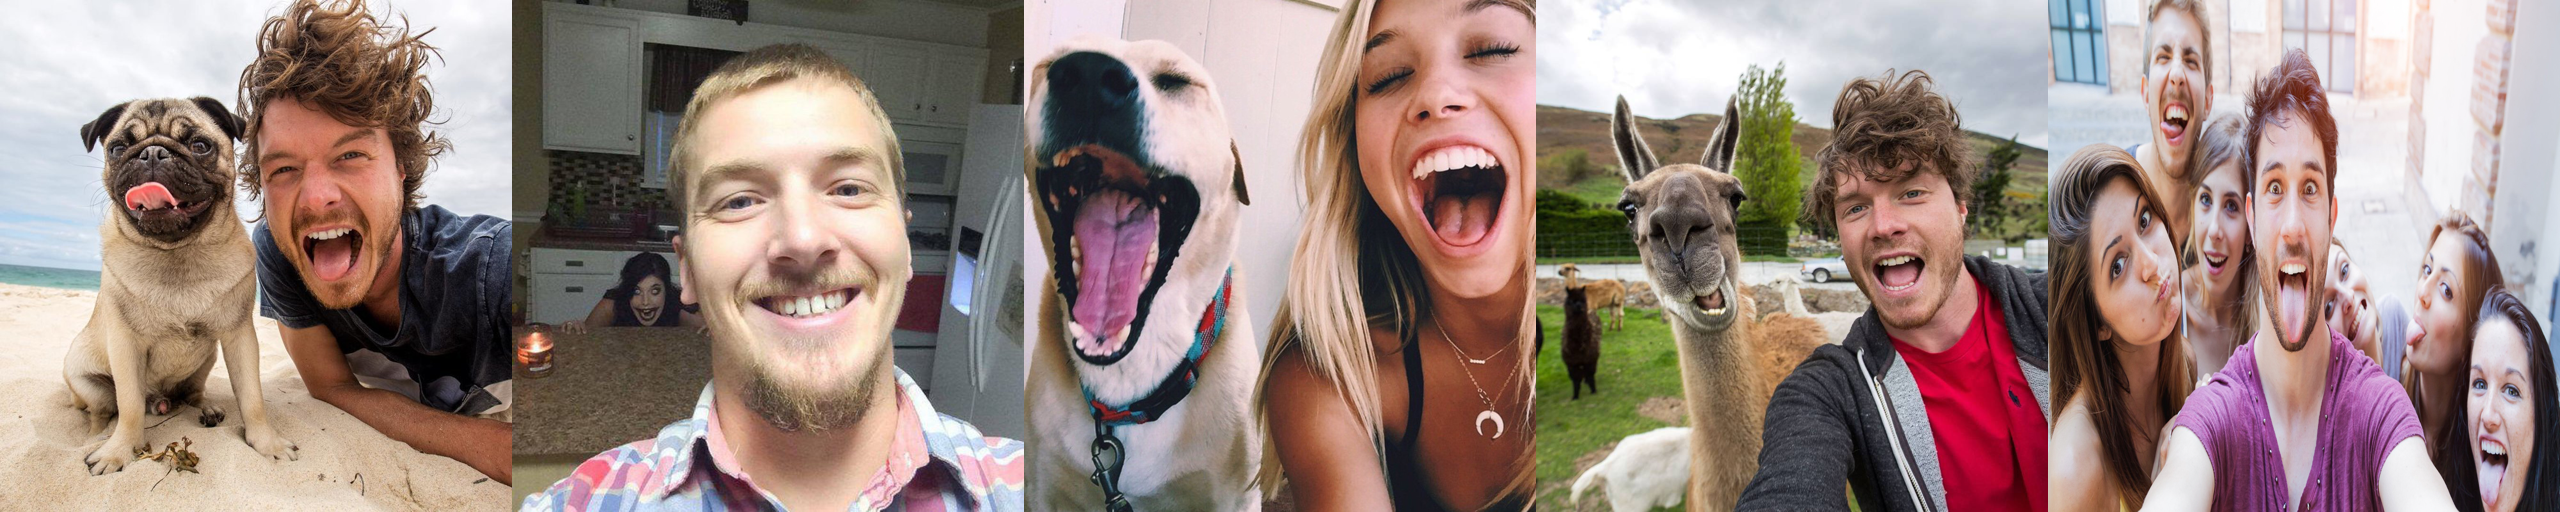

In [4]:
selfies_dataset = load_dataset(DATASET_NAME)
make_image_grid(selfies_dataset['train']['image'][:5], rows=1, cols=5)

In [5]:
selfies_dataset['train']['text']

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
# https://github.com/huggingface/diffusers/tree/main/examples/text_to_image
!accelerate launch --mixed_precision={MIXED_PRECISION} train_text_to_image_lora.py \
  --pretrained_model_name_or_path={BASE_MODEL} \
  --dataset_name={DATASET_NAME} --caption_column="text" \
  --resolution={RESOLUTION} --random_flip  \
  --train_batch_size={TRAIN_BATCH_SIZE} \
  --max_train_steps={MAX_TRAIN_STEPS} --checkpointing_steps={CHECKPOINTING_STEPS} \
  --learning_rate={LEARNING_RATE} --lr_scheduler={LR_SCHEDULER} --lr_warmup_steps=0 \
  --seed=421435 --enable_xformers_memory_efficient_attention \
  --output_dir={OUTPUT_DIR} \
  --report_to="wandb" --push_to_hub --hub_model_id={REPO_ID}

10/12/2023 20:26:31 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'thresholding', 'dynamic_thresholding_ratio', 'timestep_spacing', 'sample_max_value', 'clip_sample_range', 'variance_type'} was not found in config. Values will be initialized to default values.
You are using a model of type clip_vision_model to instantiate a model of type clip. This is not supported for all configurations of models and can yield errors.
{'force_upcast', 'scaling_factor'} was not found in config. Values will be initialized to default values.
{'cross_attention_norm', 'transformer_layers_per_block', 'num_attention_heads', 'encoder_hid_dim', 'conv_in_kernel', 'addition_embed_type', 'time_embedding_dim', 'resnet_skip_time_act', 'upcast_attention', 'conv_out_kernel', 'class_embeddings_concat', 'mid_block_only_cross_attention', 'resnet_time_scale_shift', 'resnet_out_scale_factor', 'timestep_post_act', 'time_em

# Inference


In [7]:
source_image_path = "https://huggingface.co/lllyasviel/sd-controlnet-scribble/resolve/main/images/bag.png" #@param{type: 'string'}
text_prompt = 'Bag' #@param{type: 'string'}
text_prompt_with_style = "a neon light bag" # @param {type:"string"}

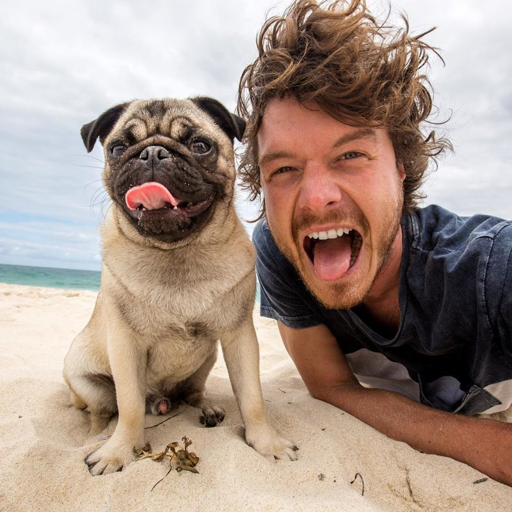

In [8]:
style_image = selfies_dataset['train']['image'][0]
style_image

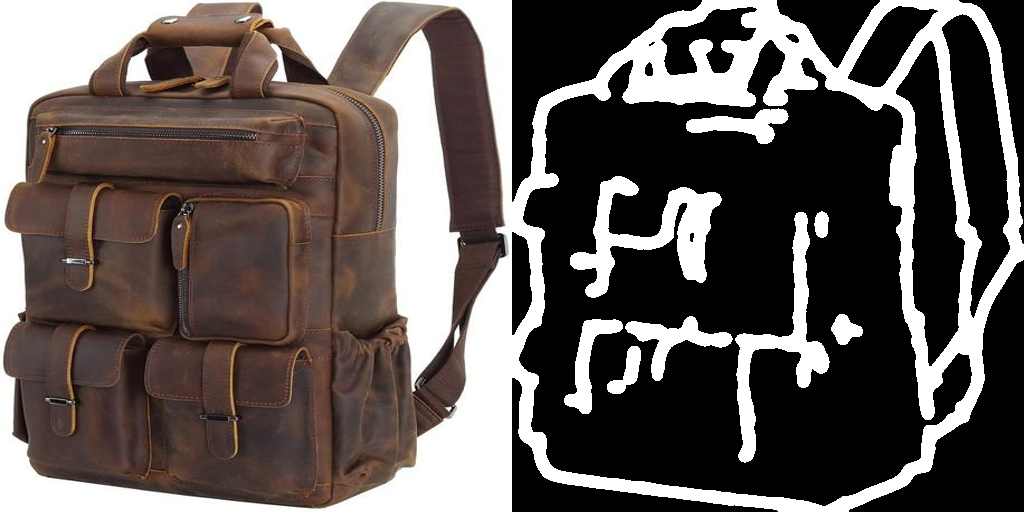

In [9]:
source_image = load_image(source_image_path).resize((512, 512))
hed = HEDdetector.from_pretrained("lllyasviel/Annotators")
scribble_image = hed(source_image, scribble=True)
make_image_grid([source_image, scribble_image], rows=1, cols=2)

Для проведения опытов над моделью попробуем четыре варианта:

1. Сгенерировать изображение из скетча без дообученной части.
2. Сгенерировать изображение из скетча, используя **[style]**.
3. Cгенерировать изображенние, используя дополнительное изображение стиля.
4. Сгенерировать изображение, используя **[style]** и дополнительное изображение стиля.



In [10]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-scribble", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    BASE_MODEL, controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)
pipe.unet.load_attn_procs(REPO_ID)
pipe.to('cuda')

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

vae\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

ValueError: Pipeline <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> expected {'feature_extractor', 'tokenizer', 'vae', 'scheduler', 'safety_checker', 'unet', 'controlnet', 'text_encoder'}, but only {'feature_extractor', 'scheduler', 'safety_checker', 'vae', 'unet', 'controlnet'} were passed.

### With **[style]**

In [ ]:
images = pipe(text_prompt_with_style, scribble_image,
              num_inference_steps=10, num_images_per_prompt=5, guidance_scale=9).images
make_image_grid(images, rows=1, cols=5)

### W/o **[style]**

In [ ]:
images = pipe(text_prompt, scribble_image,
              num_inference_steps=10, num_images_per_prompt=5, guidance_scale=9).images
make_image_grid(images, rows=1, cols=5)

In [ ]:
del controlnet, pipe
torch.cuda.empty_cache()

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-scribble", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    BASE_MODEL, controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)
pipe.unet.load_attn_procs(REPO_ID)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

### With input style image and w/o **[style]**

In [ ]:
images = pipe(text_prompt, image=style_image, control_image=scribble_image,
              num_inference_steps=10, num_images_per_prompt=5, guidance_scale=10).images
make_image_grid(images, rows=1, cols=5)

### With input style image and **[style]**

In [ ]:
images = pipe(text_prompt_with_style, image=style_image, control_image=scribble_image,
              num_inference_steps=10, num_images_per_prompt=5, guidance_scale=10).images
make_image_grid(images, rows=1, cols=5)

# Conclusion

Из всех экспериментов, наиболее близок к запросу последний эксперимент, с (1) использованием *предобученной модели*, входных изображений (2) *сеттинга* и скетча, а также использование (3) *текстового описания*, которое *соответствует стилю*.

Также 